In [1]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit
from shapely import affinity
from skimage.measure import approximate_polygon
import math
import warnings

# warnings.filterwarnings('ignore')
all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
# 这里要控制精度
all_land.geometry = all_land.geometry.apply(shapely.set_precision, grid_size=0.05)
# 对当前 all_land 添加一个 mean_slope 字段 [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]
all_land['mean_slope'] = [3.37, 7.38, 6.07, 3.94, 6.53, 7.46, 7.62]

all_land

,NAME,LAYER,周长,闭合面积,geometry,mean_slope
0,地2,Unknown Area Type,315.38 m,0.001833 sq km,"POLYGON ((440417.600 4397401.450, 440401.850 4...",3.37
1,地3,Unknown Area Type,182.65 m,0.001528 sq km,"POLYGON ((440478.950 4397335.400, 440484.500 4...",7.38
2,地4,Unknown Area Type,247.41 m,0.00125 sq km,"POLYGON ((440472.250 4397608.050, 440469.000 4...",6.07
3,地5,Unknown Area Type,143.98 m,0.000743 sq km,"POLYGON ((440450.050 4397795.250, 440451.850 4...",3.94
4,地6,Unknown Area Type,120.25 m,0.000631 sq km,"POLYGON ((440352.800 4397768.750, 440351.250 4...",6.53
5,地7,Unknown Area Type,147.18 m,0.001222 sq km,"POLYGON ((440315.750 4397785.800, 440309.100 4...",7.46
6,地1_区,Unknown Area Type,442.09 m,0.004246 sq km,"POLYGON ((440410.850 4397414.750, 440398.850 4...",7.62


split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  12
Num of Polygon lines:  20
Not on Convex:  11
Num of convex_hull:  7
Num of Polygon lines:  9
Not on Convex:  4


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


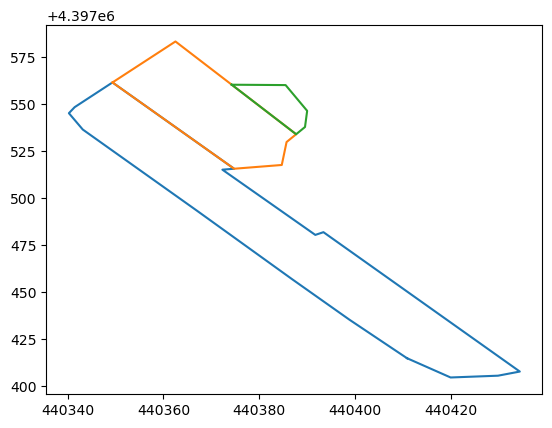

In [2]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 6)
# single_land.plot()
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)

当前田块角度： 117.06086972480475


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


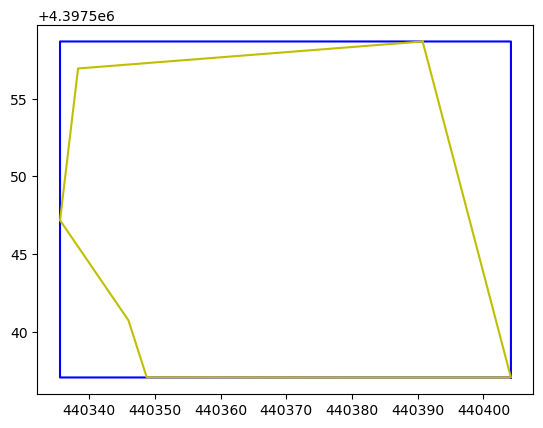

In [3]:
single_polygon = split_polygon[1]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
mabr = single_polygon.minimum_rotated_rectangle
_, ax = plt.subplots()
ax.plot(*mabr.exterior.xy, color='b')
ax.plot(*single_polygon.exterior.xy, color='y')

8.997914123272404


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


0    MULTIPOLYGON (((440395.113 4397537.057, 440395...
dtype: geometry


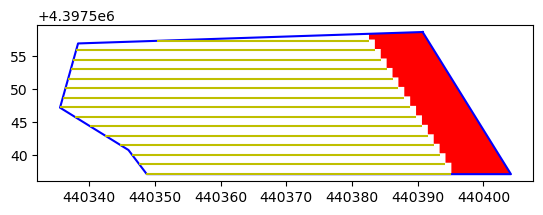

In [4]:
corrected_swath_width = CPP_Planner_Kit.get_corrected_swath_width(swath_width=1.45, slope=6)
headland_width, theta = CPP_Planner_Kit.calc_headland_width(turning_radius=4.5, swath_width=corrected_swath_width,
                                                            vehicle_length=6.3
                                                            , vehicle_width=1.9)
print(headland_width)
path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(
    land=gpd.GeoDataFrame(geometry=[single_polygon]), step_size=corrected_swath_width, along_long_edge=False,
    headland='right', head_land_width=headland_width
)
# 显示
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y')
headland.plot(ax=ax, color='r')
print(headland)

####  开始生成转向路径

In [5]:
path
# 由于是从下往上生成的，因此可以直接从第二根路径开始计算

,geometry
0,"LINESTRING (440395.113 4397537.157, 440348.693..."
1,"LINESTRING (440394.218 4397538.599, 440347.598..."
2,"LINESTRING (440393.322 4397540.041, 440346.503..."
3,"LINESTRING (440392.427 4397541.483, 440344.768..."
4,"LINESTRING (440391.531 4397542.925, 440342.438..."
5,"LINESTRING (440390.636 4397544.367, 440340.107..."
6,"LINESTRING (440389.740 4397545.809, 440337.776..."
7,"LINESTRING (440388.845 4397547.251, 440335.587..."
8,"LINESTRING (440387.949 4397548.693, 440335.993..."
9,"LINESTRING (440387.054 4397550.135, 440336.398..."


In [6]:
paths = path.geometry.tolist()
print(type(paths))

<class 'list'>


<Axes: >

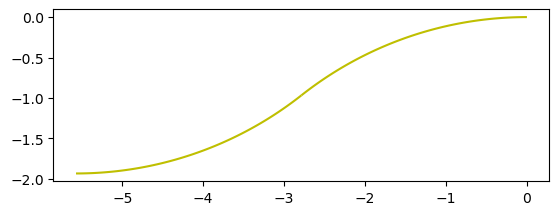

In [7]:
from CPP_Planner import CPP_Planner_TurningRail_Maker as maker
# 生成 S 路径模版
basic_S_curve = maker.gen_S_shape_curve(turning_radius=4.5, degree_step=0.2, vehicle_length=6.3, vehicle_width=1.9,
                                        swath_width=corrected_swath_width, buffer=0.3)
basic_S_curve.plot(color='y')

In [8]:
a = paths[0].coords[0]
b = paths[0].coords[1]
[a, b]

[(440395.11340387707, 4397537.1569170095),
 (440348.6932954872, 4397537.1569170095)]

LINESTRING (440397.64364017016 4397536.666577953, 440348.6932954872 4397537.1569170095)
LINESTRING (440396.74812268757 4397538.108634701, 440347.59838060086 4397538.598973758)
LINESTRING (440395.852605205 4397539.550691449, 440346.50346571446 4397540.041030506)
LINESTRING (440394.9570877224 4397540.992748197, 440344.7683570537 4397541.483087254)
LINESTRING (440394.0615702398 4397542.434804945, 440342.43772566185 4397542.925144002)
LINESTRING (440393.1660527572 4397543.876861693, 440340.10709427 4397544.36720075)
LINESTRING (440392.2705352746 4397545.318918441, 440337.7764628782 4397545.809257498)
LINESTRING (440391.375017792 4397546.7609751895, 440335.5873001076 4397547.251314246)
LINESTRING (440390.47950030945 4397548.203031938, 440335.99252391997 4397548.693370994)
LINESTRING (440389.58398282685 4397549.645088686, 440336.39774773235 4397550.135427742)
LINESTRING (440388.68846534425 4397551.087145434, 440336.80297154473 4397551.57748449)
LINESTRING (440387.79294786166 4397552.52920218

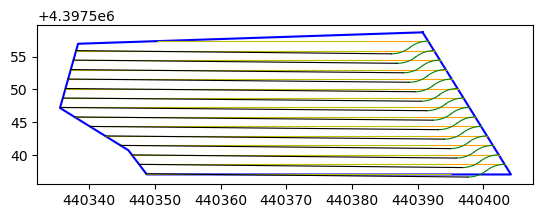

In [9]:
turning_curves = []
backward_moves = []
forward_moves = []

# 默认从第二根路径开始计算
for i in range(1, len(paths)):
    temp_path = paths[i]
    pre_path = paths[i-1]
    temp_end_point = temp_path.coords[0]
    # 地头行驶路线
    temp_forward_line = LineString((temp_end_point, (temp_end_point[0] + headland_width, temp_end_point[1])))
    # 转向 S 路线
    # TODO: 将S曲线合并了
    temp_S_line_1 = affinity.translate(basic_S_curve.geometry[0], xoff=temp_forward_line.coords[-1][0], yoff=temp_forward_line.coords[-1][1], zoff=0)
    temp_S_line_2 = affinity.translate(basic_S_curve.geometry[1], xoff=temp_forward_line.coords[-1][0], yoff=temp_forward_line.coords[-1][1], zoff=0)
    # 倒车线
    temp_backward_line = LineString((temp_S_line_2.coords[0], pre_path.coords[1]))
    print(temp_backward_line)
    forward_moves.append(temp_forward_line)
    turning_curves.append(temp_S_line_1)
    turning_curves.append(temp_S_line_2)
    backward_moves.append(temp_backward_line)

# 测试显示
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y', linewidth=0.8)
for line in forward_moves:
    ax.plot(*line.xy, 'orange', linewidth=0.8)
for line in turning_curves:
    ax.plot(*line.xy, 'g', linewidth=0.8)
for line in backward_moves:
    ax.plot(*line.xy, 'black', linewidth=0.8)
ax.set_aspect('equal')

In [13]:
f_m, t_c, b_m = maker.gen_S_turning_paths_in_polygon(path, 0, 4.5, 6.3, 1.9, 1.45, 9, 0.3)
print(type(f_m))

<class 'geopandas.geodataframe.GeoDataFrame'>


<Axes: >

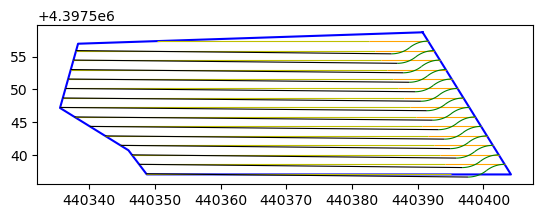

In [14]:
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, 'b')
path.plot(ax=ax, color='y', linewidth=0.8)
f_m.plot(ax=ax, color='orange', linewidth=0.8)
t_c.plot(ax=ax, color='g', linewidth=0.8)
b_m.plot(ax=ax, color='black', linewidth=0.8)